In [35]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.fits import getdata
from PIL import Image
from IPython.utils.io import capture_output
import efficientnet_pytorch
from sklearn.neighbors import NearestNeighbors
import time
import sys


transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.225, 0.225, 0.225]),
        ])

def fits_numpy(path, folder, size = 51):
    folder_path = os.path.join(path,folder)
    files= os.listdir(folder_path)
    files=np.sort(files)
    images = np.zeros((len(files), size , size,3), dtype= np.float32)
    for i in range(len(files)):
        file = files[i]
        img = getdata(os.path.join(folder_path , file))
        img = Image.fromarray(img).convert('RGB')
        img= np.array(img)          
        images[i]=img
    return images,files

def normalize(images):
    min_val = np.min(images)
    max_val = np.max(images)
    range_val = max_val - min_val
    normalized_images = ((images - min_val) / range_val)
    return normalized_images

class NumpyDataset(Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        if self.transform:
            x = Image.fromarray(x.astype(np.uint8))
            x = self.transform(x)
        return x
    
    def __len__(self):
        return len(self.data)

@torch.no_grad()
def get_latent_vectors(network, train_loader, device):
    network.eval()
    latent_vectors = []
    for cnt, x in enumerate(train_loader):
        x = x.to(device) 
        latent_vectors.append(network.extract_features(x).mean(dim=(2,3)))
    latent_vectors = torch.cat(latent_vectors).cpu().numpy()
    return latent_vectors  

def blockPrinting(func):
    def func_wrapper(*args, **kwargs):
        with capture_output():
            value = func(*args, **kwargs)
        return value
    return func_wrapper

def blockPrint():
    sys.stdout = open(os.devnull, 'w')

def enablePrint():
    sys.stdout = sys.__stdout__

@blockPrinting
def get_features(loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     blockPrint()
    network = efficientnet_pytorch.EfficientNet.from_pretrained('efficientnet-b0')
#     enablePrint()    
    network.to(device)
    network.eval()
    features = get_latent_vectors(network, loader, device)
    return features

def get_nns(query, neigh):
    res = neigh.kneighbors(query)
    similar = res[1][0]
    dists = res[0][0]
    return similar, dists

def searchOutliers(objpath,rootpath="./",size=51,plot=True,timeStamp=True):
    newImgs, files= fits_numpy(rootpath,objpath,size) #select the path to the images and select the band folder of the images.
    dataset = NumpyDataset(newImgs, transform = transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False, num_workers=8)
    features = get_features(loader)
    neigh = NearestNeighbors(n_neighbors=16)
    neigh.fit(features)
    query_features = features[0].reshape(1, -1)
    similar, dists = get_nns(query_features, neigh)
    listaDist=[]
    for indice in range(features.shape[0]):
        query_features = features[indice].reshape(1, -1)
        similar, dists = get_nns(query_features, neigh)
        listaDist.append(dists[1])
    stackedDist=listaDist[0]
    outliersList=[]
    newplot=plot
    for arg in range(1,len(listaDist)):
        if (listaDist[arg])>=stackedDist:
            if newplot:
                plt.hist(listaDist, color="#00afec", bins=20, label = "distribution of distances")
                plt.axvline(x = stackedDist, color = '#164c9d', label = 'position of the stacked')
                plt.legend()
                plt.title(objpath)
                plt.show()
                newplot=False
            if plot:
                plt.imshow(newImgs[arg,:,:,0])
                plt.title(files[arg])
                plt.show()
                print(files[arg])
            outliersList.append(files[arg]) 
#             print(arg,files[arg]) 
            t = time.localtime()
    if not(newplot) and timeStamp:
        current_time = time.strftime("%H:%M:%S", t)
        print(current_time)
        print(80*"-")
    return outliersList

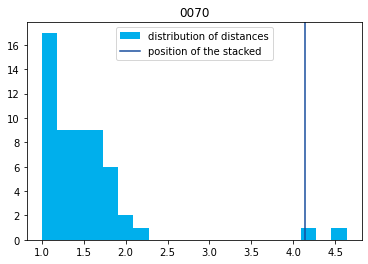

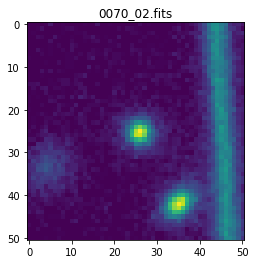

0070_02.fits
['0070_02.fits']


In [36]:
rootpath="LS_cutouts"
objpath="0070"
outliersList=searchOutliers(objpath,rootpath=rootpath,size=51,plot=True,timeStamp=False)
print(outliersList)


In [ ]:

# import torchvision
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.ensemble import IsolationForest
# 
# import imageio
# 
# import multiprocessing
# from IPython.display import clear_output